<a href="https://colab.research.google.com/github/LuFernandez/imagaynes/blob/master/Restauracion_imgs/restore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP - Restauración de Imágenes
###Ezequiel Vijande
###Lucero Guadalupe Fernandez

###Imports a utilizar

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy.fft import fft2,fftshift,ifft2,ifftshift

####Cargamos imágenes

In [2]:
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/Restauracion_imgs/pic/lenna.png
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/Restauracion_imgs/pic/barraxx.bmp
clear_output()

####mostramos imagen original y definimos funciones a utilizar

In [3]:
#definimos la funcion del filtro: recibe el tamaño del kernel,
#y la imagen sobre la que se aplica el filtro, se usa filtro promediador
def ApplyBlur(img, kernel): #lowpass
  kernel = ExpandKernel(kernel, (img).shape)
  blur = fft2(img[:,:,0])*fft2(kernel)
  return np.real(fftshift(ifft2(blur)))

def ApplyNoise(img, std=1):
  row,col = img.shape
  mean = 0
  gauss = np.random.normal(mean,std,(row,col))
  gauss = gauss.reshape(row,col)
  noisy = img.astype(float) + gauss.astype(float)
  return noisy.astype(np.float)


def ExpandKernel(kernel, size):
  delta = np.zeros((size[0], size[1]), dtype=float)
  delta[size[0]//2,size[1]//2] = 1
  return cv2.filter2D(delta, -1, kernel)

#https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def gkern(kernlen=21, std=3):
  """Returns a 2D Gaussian kernel array."""
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
  gkern2d = np.outer(gkern1d, gkern1d)
  gkern2d /= np.sum(gkern2d)
  return gkern2d


def ApplyInverseFilter(degraded_og, kernel):
  degraded = degraded_og.copy()
  kernel = ExpandKernel(kernel, (degraded).shape)
  #Kernel Spectrum
  H = fft2(kernel) 
  #Degraded image spectrum
  G = fft2(degraded)
  # Inverse Filter 
  F_hat = fftshift(G/(H))
  restored = np.real(fftshift(ifft2(ifftshift(F_hat))))
  return restored


In [4]:
def mse(img1, original):
  return np.mean((img1-original[:,:,0])**2)
  
#ploteamos secuencia
def MakeSubplot(img,fig,row,column,index,title):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.axis('off')
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)

##1. Inverse Filter

###a. Blur

MSE entre imagen original y la imagen con blur es: 85.66060325249862
MSE entre imagen original y la restaurada es: 3.007231768621587e-23


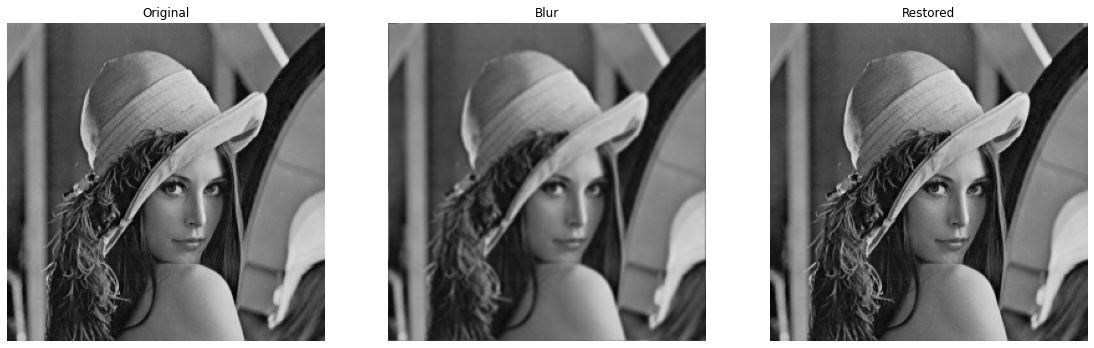

In [5]:
#imagen original
lenna = cv2.imread('lenna.png')

#kernel = np.full((3, 3), 1)/(3**2)
kernel = gkern(kernlen=3, std=20)

degraded = ApplyBlur(lenna, kernel)
blurred = degraded.copy()
restored = ApplyInverseFilter(degraded, kernel)

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(degraded.astype(int),fig_a,1,3,2,title="Blur")
MakeSubplot(restored,fig_a,1,3,3,title="Restored")

print('MSE entre imagen original y la imagen con blur es:', mse(blurred, lenna))
print('MSE entre imagen original y la restaurada es:', mse(restored, lenna))

Se obtiene un muy bajo error usando Inverse filter en el caso de blur.

###b. Blur + Noise

MSE entre imagen original y la imagen con blur+noise es: 185.24141997448092
MSE entre imagen original y la restaurada es: 404.6645166755629


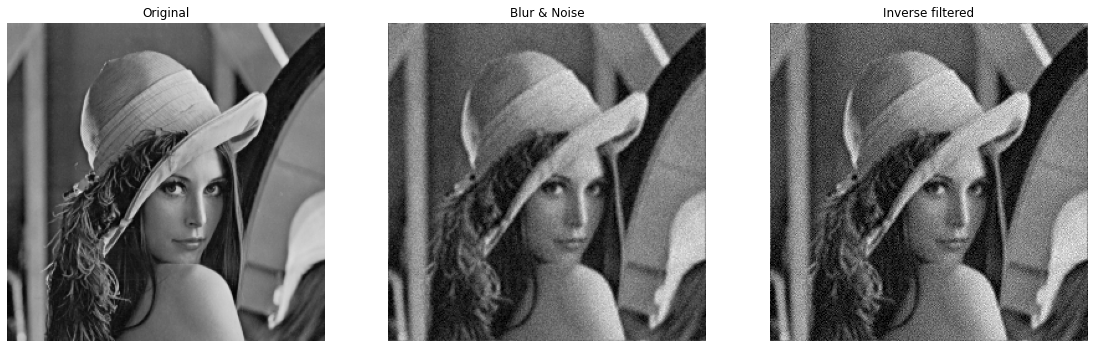

In [6]:
#Original
blur_noisy = ApplyNoise(blurred,std=10)
kernel = gkern(kernlen=3, std=.5)
restored_noisy = ApplyInverseFilter(blur_noisy, kernel)

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(blur_noisy.astype(int),fig_a,1,3,2,title="Blur & Noise")
MakeSubplot(restored_noisy.astype(int),fig_a,1,3,3,title="Inverse filtered")

print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, lenna))
print('MSE entre imagen original y la restaurada es:', mse(restored_noisy, lenna))

En este caso (blur+noise) no es de utilidad usar Inverse filter.

## 2- Wiener filter (Blur + Noise)

In [7]:
def WienerRestore(kernel,degraded_img,noise_std=None,original_img=None):
  expanded_kernel = ExpandKernel(kernel, degraded_img.shape)
  H = np.fft.fft2( np.fft.ifftshift(expanded_kernel) )
  H_power = np.power(abs(H), 2* np.ones(H.shape))
  L= 1e-1
  if (noise_std == None):
    W = np.conjugate(H) / (H_power + L)
  else:
    img_mod = abs( np.fft.fft2( original_img[:,:,0] ) )
    Sxx = np.power( img_mod, 2* np.ones(img_mod.shape)) / (img_mod.shape[0] * img_mod.shape[1])
    Snn = (noise_std*noise_std) * np.ones( Sxx.shape ) 
    W = np.conjugate(H) / (H_power + (Snn/Sxx) ) 
  F_hat = np.fft.fft2( degraded_img ) * W
  aux = np.nan_to_num(F_hat)
  restored = abs( np.fft.ifft2( aux )  ) 
  restored[restored < 0] = 0
  restored[restored > 255] = 255
  return restored.astype(int)

MSE entre imagen original y la imagen con blur+noise es: 482.0763378684382
MSE entre imagen original y la restaurada es: 146.1210174560547


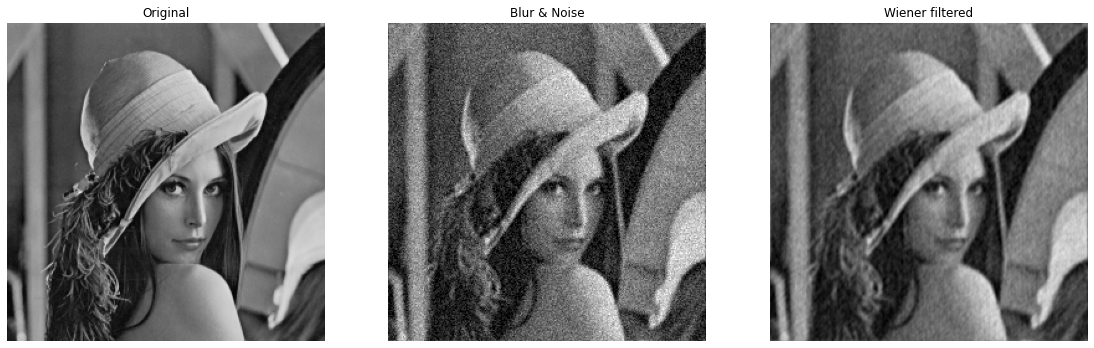

In [8]:
#Original
std_ = 20
blur_noisy = ApplyNoise(degraded,std=std_)
restored_noisy = WienerRestore(kernel.astype(float),blur_noisy.astype(float),noise_std=std_,original_img=lenna.astype(float))

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(blur_noisy.astype(int),fig_a,1,3,2,title="Blur & Noise")
MakeSubplot(restored_noisy.astype(int),fig_a,1,3,3,title="Wiener filtered")

print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, lenna))
print('MSE entre imagen original y la restaurada es:', mse(restored_noisy, lenna))

## 3- Blind deconvolution

Para Blind Deconvolution se utilizó el algoritmo de Richardson-Lucy del paquete skimage. Recibe como argumento la imagen desenfocada, es decir la imagen a restaurar y una estimación inicial de la PSF (point spread function). Consideramos como estimación una matriz de 9x9 normalizada.
La imagen restaurada gana enfoque mediante las iteraciones de la función.

Basado en: 
William Hadley Richardson, “Bayesian-Based Iterative Method of Image Restoration”, J. Opt. Soc. Am. A 27, 1593-1607 (1972).

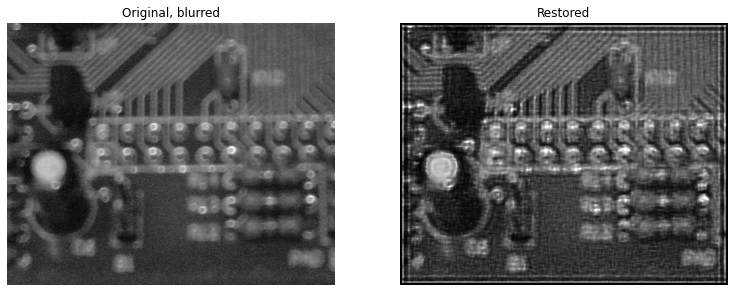

In [9]:
from skimage import restoration

barraxx = cv2.imread('barraxx.bmp', cv2.IMREAD_GRAYSCALE)

n = 9
m = 9
psf = np.ones((n, m)) / (n*m)
# Restore Image using Richardson-Lucy algorithm
restored = restoration.richardson_lucy(barraxx/255.0, psf, iterations=25)

fig_a = plt.figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
MakeSubplot(barraxx,fig_a,1,2,1,title="Original, blurred")
MakeSubplot(restored*255.0,fig_a,1,2,2,title="Restored")

## 4- Motion Blur


En este caso, en primer lugar se simula un motion blur, también conocido como desenfoque por movimiento, que es un desenfoque que sigue el movimiento del objeto o de la cámara. Y a continuación se busca eliminar esta degradación utilizando el Filtro de Weiner previamente desarrollado.

In [10]:
def ApplyMotionBlurnNoise(img, size, snr):
  row,col,_= np.shape(img)
  # generating the kernel
  kernel = np.zeros((size, size))
  kernel[int((size-1)/2), :] = np.ones(size)
  kernel = kernel / size

  # applying the kernel to the input image
  output = cv2.filter2D(img.astype(float), -1, kernel)
  output = output[:,:,0]
  
  #agrego noise
  blurr_std =  output.std()
  sigma_noise = np.sqrt((blurr_std)**2*10**(-SNR_dB/10));
  noise = np.random.normal(0, sigma_noise, (row,col))
  noise = noise.reshape(row, col)
  #Se lo agrego a la imagen blurreada
  output+= noise

  return output

MSE entre imagen original y la imagen con motion blur es: 724.2630878576293
MSE entre imagen original y la restaurada es: 566.2438507080078


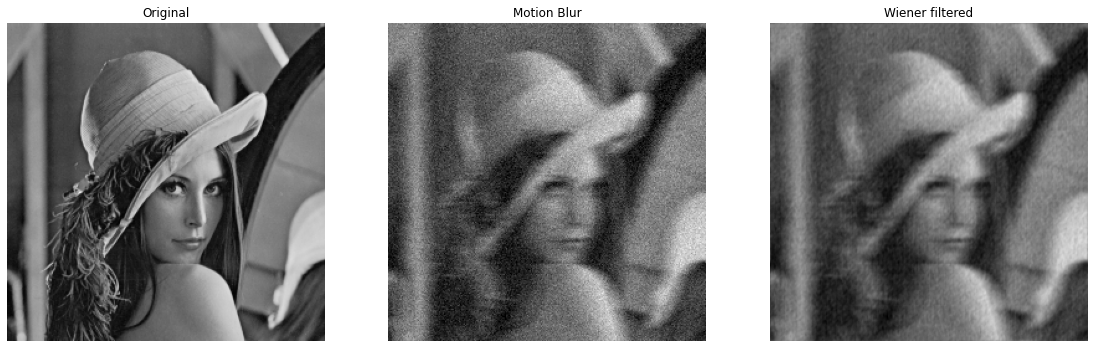

In [11]:
#Original
lenna = cv2.imread('lenna.png')

#aplico motion blur
blur_size = 15
SNR_dB = 10

degraded = ApplyMotionBlurnNoise(lenna, size=blur_size, snr=SNR_dB)

restored = WienerRestore(gkern(kernlen=3, std=.5), degraded.astype(float), noise_std=blur_size, original_img=lenna.astype(float))

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(degraded.astype(int),fig_a,1,3,2,title="Motion Blur")
MakeSubplot(restored.astype(int),fig_a,1,3,3,title="Wiener filtered")

print('MSE entre imagen original y la imagen con motion blur es:', mse(degraded, lenna))
print('MSE entre imagen original y la restaurada es:', mse(restored, lenna))

## 5- Regularizacion y métodos iterativos

### Regularizacion determinista

In [12]:
def DeterministicRegularization(img,H,alpha,d_kernel=None):
  if d_kernel == None:
    C_mat = np.array( [
                       [0,-0.25,0],
                      [-0.25,-1,-0.25],
                        [0,-0.25,0]
                      ])
  else:
    C_mat = d_kernel
  aux_kernel = np.matmul(H,np.transpose(H)) + alpha* np.matmul( np.transpose(C_mat),C_mat )
  new_kernel = np.matmul(aux_kernel, np.transpose(H))
  return cv2.filter2D(img.astype(float), -1, new_kernel)

MSE entre imagen original y la imagen con blur+noise es: 482.0763378684382
MSE entre imagen original y la restaurada es: 294.3729960915268


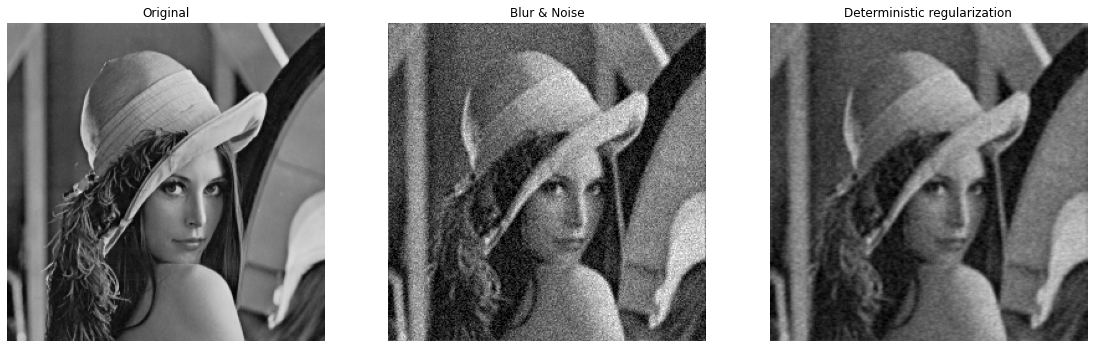

In [22]:
alpha=1
regularization_restored = DeterministicRegularization(blur_noisy,gkern(kernlen=3, std=20),alpha)
#Graficas
fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(blur_noisy.astype(int),fig_a,1,3,2,title="Blur & Noise")
MakeSubplot(regularization_restored.astype(int),fig_a,1,3,3,title="Deterministic regularization")

print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, lenna))
print('MSE entre imagen original y la restaurada es:', mse(regularization_restored, lenna))